In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

objpoints = [] 
imgpoints = [] 

images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    else:
        im_num = int(fname.split('.')[0][-1])
        if im_num == 5:
            ret, corners = cv2.findChessboardCorners(gray, (7,5), None)
            objp = np.zeros((5*7,3), np.float32)
            objp[:,:2] = np.mgrid[0:5,0:7].T.reshape(-1,2)
        elif im_num == 4:
            ret, corners = cv2.findChessboardCorners(gray, (6,5), None)
            objp = np.zeros((5*6,3), np.float32)
            objp[:,:2] = np.mgrid[0:6,0:5].T.reshape(-1,2)
        elif im_num == 1:
            ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
            objp = np.zeros((5*9,3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
        assert ret
        objpoints.append(objp)
        imgpoints.append(corners)

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.T.shape, None, None)

In [3]:
img = cv2.imread(images[10])
dst = cv2.undistort(img, mtx, dist, None, mtx)

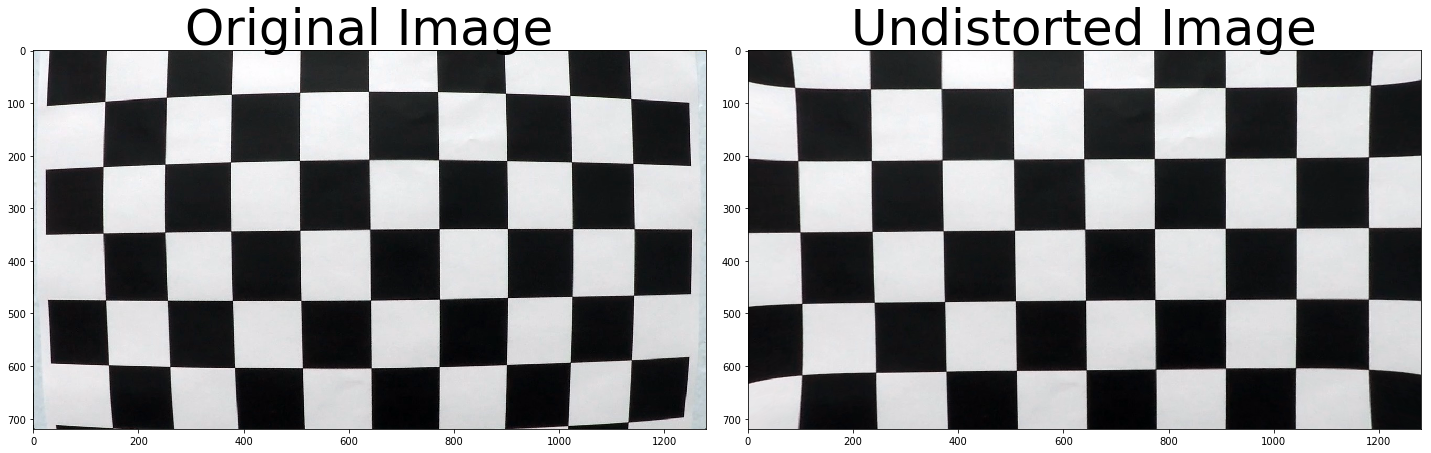

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 30))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 50)

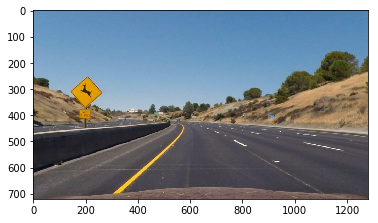

In [755]:
im_num = 2
distorted = plt.imread('test_images/test' + str(im_num) + '.jpg')
img = cv2.undistort(distorted, mtx, dist, None, mtx)
plt.imshow(img)

In [756]:
# Perspective transform

straight = plt.imread('test_images/straight_lines1.jpg')
straight_gray = cv2.cvtColor(straight, cv2.COLOR_RGB2GRAY)

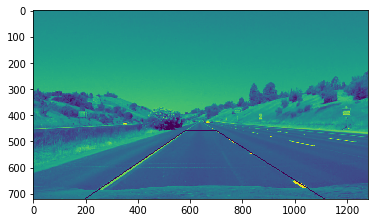

In [757]:
trap_pts = np.array([[197,720], [580, 460], [702, 460], [1115, 720]], np.int32)
trap = np.copy(straight_gray)
trap = cv2.polylines(trap, [trap_pts], True, (0, 255, 0), thickness = 2)
plt.imshow(trap)

In [758]:
src_pts = np.float32(trap_pts)
dest_pts = np.array([[350, 720], [350, 0], [970, 0], [970, 720]], np.float32)

In [759]:
M = cv2.getPerspectiveTransform(src_pts, dest_pts)
Minv = cv2.getPerspectiveTransform(dest_pts, src_pts)

In [760]:
def warp(img, M):
    warped = cv2.warpPerspective(img, M, (1280, 720), flags = cv2.INTER_LINEAR)
    return warped

In [761]:
def color_thresh(img, thresh = (0, 255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue = hsv[:,:,0]
    sat = hsv[:,:,1]
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    binary_output = np.zeros_like(hue)

    binary_output[(((hue > 20) & (hue < 30)) & ((sat > 130) & (sat < 230))) | ((blue > 190)&(blue < 255))] = 1
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(binary_output,kernel,iterations = 1)
    
    return binary_output

# Derivative thresholding

# def abs_sobel_thresh(img, orient='x', ksize = 3, thresh = (0, 255)):
    
#     assert ksize % 2 == 1
# #   Using gray images to identify white lines better
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# #     sat = hls[:,:,2]
#     if orient == 'x':
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = ksize)
#     else:
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = ksize)
#     abs_sobel = np.absolute(sobel)
#     scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
#     binary_output = np.zeros_like(scaled_sobel)
#     binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
#     return binary_output

def mag_thresh(img, ksize = 3, thresh = (0, 255)):
    
    assert ksize % 2 == 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    sobelx = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize = ksize)
    sobely = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize = ksize)
#   scaling magnitude of y because it introduces noise
    abs_sobelxy = np.sqrt(sobelx**2 + 0.01 * sobely**2)
    scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    
    return binary_output

# def dir_thresh(img, ksize = 3, thresh = (0, np.pi/2)):

#     assert ksize % 2 == 1
    
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# #     sat = hls[:,:,2]
    
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = ksize)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = ksize)
#     abs_sobelx = np.absolute(sobelx)
#     abs_sobely = np.absolute(sobely)
#     grad = np.arctan2(abs_sobely, abs_sobelx)
#     binary_output = np.zeros_like(gray)
#     binary_output[(grad > thresh[0]) & (grad < thresh[1])] = 1
# #   cv2 morphological transform
#     kernel = np.ones((5,5), np.uint8)
#     binary_output = cv2.morphologyEx(binary_output, cv2.MORPH_OPEN, kernel)
    
#     return binary_output

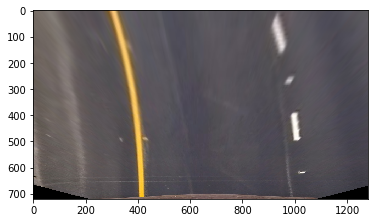

In [762]:
_input = cv2.undistort(img, mtx, dist, None, mtx)
_input = cv2.GaussianBlur(_input, (5,5), 0)
_input = warp(img, M)
plt.imshow(_input)

In [763]:
# gradx = abs_sobel_thresh(_input, orient = 'x', ksize = 9, thresh = (20, 100))
# grady = abs_sobel_thresh(_input, orient = 'y', ksize = 9, thresh = (20, 100))
mag_binary = mag_thresh(_input, ksize = 9, thresh = (30, 100))
# dir_binary = dir_thresh(_input, ksize = 13, thresh = (0.8, 1.2))
color_binary = color_thresh(_input)

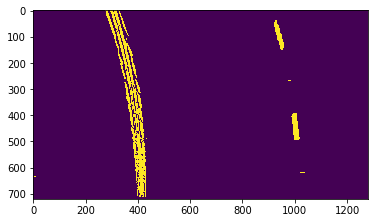

In [764]:
combined = np.zeros_like(dir_binary)
combined[(color_binary == 1) | (mag_binary == 1)] = 1
plt.imshow(combined)

In [765]:
def reinforce(img, kernel = (5, 5)):
    kernel = np.ones(kernel, np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

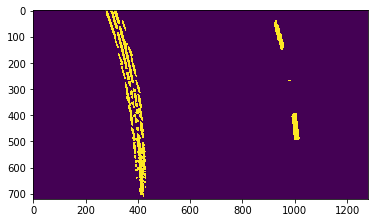

In [769]:
binary_warped = reinforce(combined)
half = binary_warped[:binary_warped.shape[0]//2,:]
plt.imshow(binary_warped)

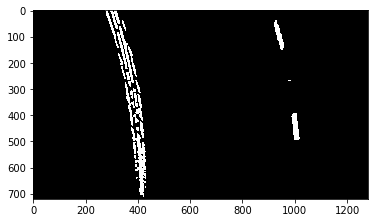

In [767]:
plt.imshow(np.dstack((binary_warped, binary_warped, binary_warped))*255)

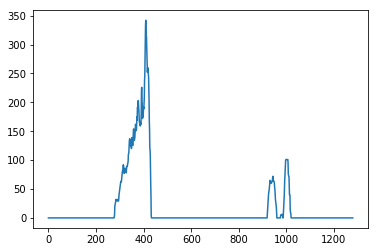

In [768]:
histogram = np.sum(binary_warped, axis = 0)
plt.plot(histogram)

In [91]:
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


In [100]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
print(lefty.shape, leftx.shape, rightx.shape, righty.shape)

(26957,) (26957,) (6334,) (6334,)


In [102]:
ploty = np.linspace(0, 719, num=720)
np.max(ploty)

719.0

In [105]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
binary_warp

720